In [1]:
import numpy as np
import pandas as pd
import polars as pl
import sys
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px


pd.set_option('display.max_columns',None)
import psycopg2


#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Algorithms to use
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Metrics to evaluate the model
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

import warnings
warnings.filterwarnings("ignore")

#importing PCA and TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
import pandas as pd

truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Truthset_CHROM_POS_REF_ALT.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t', header=0, low_memory=False, encoding='latin-1')

# Read your main data file
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/MODY_new_05_10_2023/All_5samples.xlsx')
df['CHROM'] = 'chr' + df['Chr:Pos'].str.split(':').str[0]
df['POS'] = df['Chr:Pos'].str.split(':').str[1].astype(int)
df['REF'] = df['Ref/Alt'].str.split('/').str[0]
df['ALT'] = df['Ref/Alt'].str.split('/').str[1]
columns_to_check = ['CHROM', 'POS', 'REF', 'ALT']
# Use drop_duplicates to remove duplicated rows based on the specified columns
df = df.drop_duplicates(subset=columns_to_check)

# Define the sample, tool, VAF filter, and DP filter combinations
samples = ['12652705', '12652707', '12652709', '12652710', '12652712']
tools = ['BCFTOOL', 'VARSCAN2', 'MUTECT2', 'HAPLOTYPECALLER', 'DEEPVARIANT']
vaf_filters = [0.1, 0.01, 0.001]
dp_filters = [10, 18, 20, 22, 30]

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Variant_classification', 'Tool', 'Sample', 'VAF_Filter', 'DP_Filter', 'Counts'])

# Iterate through combinations and calculate counts
for sample in samples:
    for tool in tools:
        for vaf_filter in vaf_filters:
            for dp_filter in dp_filters:
                # Read the corresponding VCF file for the tool
                vcf_file_path = f'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/{sample}_{tool}.vcf'
                vcf = pd.read_csv(vcf_file_path, comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
                vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']

                # Extract VAF based on the tool
                if tool == 'BCFTOOL':
                    # Customize VAF extraction for BCFTOOL
                    vcf['AD'] = vcf['SAMPLE'].str.split(':').str[6]
                    vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
                    vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
                    vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
                    # For BCFTOOL, you can choose not to filter based on 'DP'
                    filtered_data = vcf[vcf['VAF'] >= vaf_filter]
                elif tool == 'VARSCAN2':
                    # Customize VAF extraction for VARSCAN2
                    vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
                    vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
                    vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
                    vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
                    # Apply VAF and DP filters
                    filtered_data = vcf[(vcf['VAF'] >= vaf_filter) & (vcf['DP'] >= dp_filter)]
                elif tool == 'MUTECT2':
                    # Customize VAF extraction for MUTECT2
                    vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
                    vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
                    vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
                    vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
                    vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
                    # For MUTECT2, you can choose not to filter based on 'DP'
                    filtered_data = vcf[vcf['VAF'] >= vaf_filter]
                elif tool == 'HAPLOTYPECALLER':
                    # Customize VAF extraction for HAPLOTYPECALLER
                    vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
                    vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
                    vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
                    vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
                    vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
                    # For HAPLOTYPECALLER, you can choose not to filter based on 'DP'
                    filtered_data = vcf[vcf['VAF'] >= vaf_filter]
                elif tool == 'DEEPVARIANT':
                    # Customize VAF extraction for DEEPVARIANT
                    vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
                    vcf['AD'] = vcf['SAMPLE'].str.split(':').str[3]
                    vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
                    vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
                    vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
                    # For DEEPVARIANT, you can choose not to filter based on 'DP'
                    filtered_data = vcf[vcf['VAF'] >= vaf_filter]

                    
                filtered_data = pd.merge(truth_set, filtered_data, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'inner', sort = False)

                # Merge the VCF data with the main data (df)
                merged_data = pd.merge(filtered_data, df, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', sort=False)
                merged_data = merged_data.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])

                # To fill NaN values in the 'Classification' column with 'NA', you need to assign the result back to the column.
                merged_data['Classification'] = merged_data['Classification'].fillna('NA')

                # List of your specified priorities
                priorities = ['Pathogenic', 'Likely Pathogenic', 'VUS/Weak Pathogenic', 'VUS/Conflicting', 'VUS', 'VUS/Weak Benign', 'Likely Benign', 'Benign']

                # Function to select the highest ranked value from Original_Column
                def select_highest_ranked(row):
                    values = row['Classification'].split(',')
                    for rank in priorities:
                        if rank in values:
                            return rank
                    return None  # Return None if no rank found

                # Apply the function to create the final selected rank column
                merged_data['Classification'] = merged_data.apply(select_highest_ranked, axis=1)
                
                # Calculate counts for each variant classification
                counts = merged_data['Classification'].value_counts(dropna=False)

                # Append the results to the result_df
                for classification, count in counts.items():
                    result_df = result_df.append({
                        'Variant_classification': classification,
                        'Tool': tool,
                        'Sample': sample,
                        'VAF_Filter': vaf_filter,
                        'DP_Filter': dp_filter,
                        'Counts': count
                    }, ignore_index=True)

# Reset index for the final result DataFrame
result_df.reset_index(drop=True, inplace=True)

result_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/True_positives_data_5samples_new_27_10_2023.xlsx', index = False)
# Display the final result
print(result_df)

,Variant_classification,Tool,Sample,VAF_Filter,DP_Filter,Counts
0,Benign,BCFTOOL,12652705,0.100,10,25425
1,None,BCFTOOL,12652705,0.100,10,3281
2,Likely Benign,BCFTOOL,12652705,0.100,10,673
3,VUS/Conflicting,BCFTOOL,12652705,0.100,10,480
4,VUS/Weak Benign,BCFTOOL,12652705,0.100,10,252
...,...,...,...,...,...,...
2995,Likely Benign,DEEPVARIANT,12652712,0.001,30,825
2996,VUS/Weak Pathogenic,DEEPVARIANT,12652712,0.001,30,245
2997,VUS/Weak Benign,DEEPVARIANT,12652712,0.001,30,227
2998,VUS,DEEPVARIANT,12652712,0.001,30,28


In [7]:
result_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/True_positives_data_5samples_new_27_10_2023.xlsx', index = False)

In [6]:
import pandas as pd

truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/output.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t', header=0, low_memory=False, encoding='latin-1')
truth_set

,CHROM,POS,REF,ALT
0,chr1,65490,G,A
1,chr1,65529,C,T
2,chr1,65532,A,T
3,chr1,65552,G,A
4,chr1,65556,C,T
...,...,...,...,...
23761809,chrY,57194235,T,C
23761810,chrY,57194236,G,C
23761811,chrY,57194239,A,C
23761812,chrY,57194242,G,T


In [11]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_BCFTOOL.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[6]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
filter_var = vcf[vcf['VAF'] >= 0.1]
filter_var_DP = filter_var[filter_var['DP'] >= 10]
#filter_var_DP = vcf.copy()
filter_var_DP

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,AD,RD,A_D,VAF,DP
0,chr1,817514,rs3131971,T,C,118.3520,.,"DP=248;ADF=0,201;ADR=1,28;AD=1,229;SCR=0;VDB=0...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:145,255,0:230:0:0,201:1,28:1,229:0","1,229",1,229,0.995652,248
1,chr1,826893,rs3115849,G,A,34.4159,.,"DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:64,255,0:93:0:0,38:0,55:0,93:0","0,93",0,93,1.000000,97
2,chr1,930939,rs9988021,G,A,225.4170,.,"DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,178,0:59:0:0,53:0,6:0,59:0","0,59",0,59,1.000000,67
3,chr1,941119,rs4372192,A,G,205.4170,.,"DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:235,51,0:17:0:0,15:0,2:0,17:0","0,17",0,17,1.000000,23
7,chr1,944858,rs3748592,A,G,225.4170,.,"DP=14;ADF=0,7;ADR=0,5;AD=0,12;SCR=0;VDB=0.4033...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,36,0:12:0:0,7:0,5:0,12:0","0,12",0,12,1.000000,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79442,chrY,1387425,.,C,G,23.4340,.,"DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:53,166,0:55:0:0,14:0,41:0,55:0","0,55",0,55,1.000000,65
79443,chrY,1418109,.,C,G,25.4267,.,"DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:55,255,0:99:0:0,26:0,73:0,99:0","0,99",0,99,1.000000,111
79444,chrY,1425778,.,G,A,26.4242,.,"DP=79;ADF=0,17;ADR=0,52;AD=0,69;SCR=0;VDB=0.61...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:56,208,0:69:0:0,17:0,52:0,69:0","0,69",0,69,1.000000,79
79445,chrY,1428198,.,C,A,23.4340,.,"DP=57;ADF=0,12;ADR=0,37;AD=0,49;SCR=0;VDB=0.03...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:53,148,0:49:0:0,12:0,37:0,49:0","0,49",0,49,1.000000,57


In [12]:
mer = pd.merge(truth_set, filter_var_DP, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'inner', sort=False)
mer

,CHROM,POS,REF,ALT,rsID,QUAL,FILTER,INFO,FORMAT,SAMPLE,AD,RD,A_D,VAF,DP
0,chr1,948711,C,G,rs7522415,41.4010,.,"DP=17;ADF=1,0;ADR=11,4;AD=12,4;SCR=0;VDB=0.051...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:75,0,176:16:0:1,0:11,4:12,4:0","12,4",12,4,0.250000,17
1,chr1,948721,A,C,rs4970455,120.0800,.,"DP=18;ADF=0,1;ADR=6,8;AD=6,9;SCR=0;VDB=0.00108...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:153,0,82:15:0:0,1:6,8:6,9:0","6,9",6,9,0.600000,18
2,chr1,953779,A,C,rs13302945,225.4170,.,"DP=57;ADF=0,36;ADR=0,10;AD=0,46;SCR=0;VDB=0.44...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,138,0:46:0:0,36:0,10:0,46:0","0,46",0,46,1.000000,57
3,chr1,962933,C,T,rs375277853,152.3590,.,"DP=56;ADF=0,0;ADR=24,28;AD=24,28;SCR=0;VDB=0.2...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:185,0,169:52:0:0,0:24,28:24,28:0","24,28",24,28,0.538462,56
4,chr1,973929,T,C,rs3829738,206.4170,.,"DP=10;ADF=0,6;ADR=0,3;AD=0,9;SCR=0;VDB=0.72764...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:236,27,0:9:0:0,6:0,3:0,9:0","0,9",0,9,1.000000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28374,chrX,154901948,A,G,rs4074307,43.9289,.,"DP=18;ADF=14,4;ADR=0,0;AD=14,4;SCR=0;VDB=0.372...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:78,0,176:18:0:14,4:0,0:14,4:0","14,4",14,4,0.222222,18
28375,chrX,154903815,A,T,rs4898352,130.1590,.,"DP=44;ADF=27,17;ADR=0,0;AD=27,17;SCR=0;VDB=0.8...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:163,0,188:44:0:27,17:0,0:27,17:0","27,17",27,17,0.386364,44
28376,chrX,154929926,T,G,rs1800292,222.3760,.,"DP=86;ADF=22,21;ADR=21,16;AD=43,37;SCR=0;VDB=0...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:255,0,255:80:2:22,21:21,16:43,37:0","43,37",43,37,0.462500,86
28377,chrY,1425778,G,A,.,26.4242,.,"DP=79;ADF=0,17;ADR=0,52;AD=0,69;SCR=0;VDB=0.61...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:56,208,0:69:0:0,17:0,52:0,69:0","0,69",0,69,1.000000,79


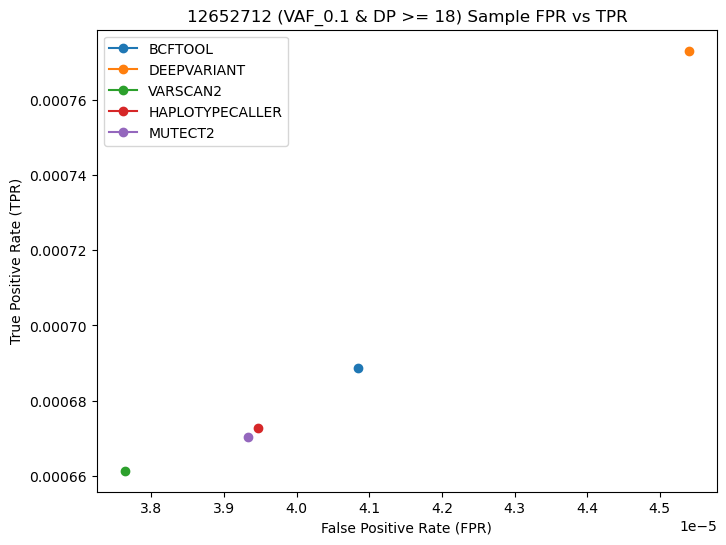

In [7]:
import matplotlib.pyplot as plt

# Data
tools = ["BCFTOOL", "DEEPVARIANT", "VARSCAN2", "HAPLOTYPECALLER", "MUTECT2"]
TP = [25641, 28790, 24625, 25050, 24962]
TN = [1008250088, 1008254674, 1008246847, 1008248698, 1008248555]
FP = [41190, 45776, 37949, 39800, 39657]
FN = [37210814, 37207665, 37211830, 37211405, 37211493]

# Initialize a figure for ROC curves
plt.figure(figsize=(8, 6))

# Iterate over tools
for i in range(len(tools)):
    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    tpr = TP[i] / (TP[i] + FN[i])
    fpr = FP[i] / (TN[i] + FP[i])

    # Plot ROC curve
    plt.plot(fpr, tpr, marker='o', label=tools[i])

# Set axis labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('12652712 (VAF_0.1 & DP >= 18) Sample FPR vs TPR')

# Add legend
plt.legend()

plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/new_output_files/12652712_VAF0.1_DP18_FPR_TPR.svg', dpi=450, bbox_inches='tight')

# Show the ROC curves
plt.show()

In [11]:
# Specify the directory where your Excel files are located
directory = r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/new_output_files/'  # Change to your directory path

# Create an empty DataFrame to store the combined data
combined_data = pd.DataFrame()

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.startswith("snp_0.1VAF") and filename.endswith(".xlsx"):
        file_path = os.path.join(directory, filename)
        data = pd.read_excel(file_path)
        combined_data = combined_data.append(data, ignore_index=True)

# Save the combined data to a new Excel file
combined_data.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/new_output_files/0.1_combined_data.xlsx', index=False)

# All 5 samples ACMG data

In [2]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/MODY_new_05_10_2023/All_5samples.xlsx')
df['CHROM'] = 'chr' + df['Chr:Pos'].str.split(':').str[0]
df['POS'] = df['Chr:Pos'].str.split(':').str[1].astype(int)
df['REF'] = df['Ref/Alt'].str.split('/').str[0]
df['ALT'] = df['Ref/Alt'].str.split('/').str[1]
columns_to_check = ['CHROM', 'POS', 'REF', 'ALT']
# Use drop_duplicates to remove duplicated rows based on the specified columns
df = df.drop_duplicates(subset=columns_to_check)
df

,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count,CHROM,POS,REF,ALT
0,1:69511,A/G,OR4F5,Default (Recessive),79501,NM_001005484.2,+,NM_001005484.2:c.484A>G,NP_001005484.2:p.Thr162Ala,missense_variant,Single Transcript Gene,"BA1,BP4",OR4F5:Allele frequency is above 0.01 recessive...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.999461,16698,16689,chr1,69511,A,G
1,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772,chr1,817514,T,C
2,1:826893,G/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.630C>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.896992,10106,9065,chr1,826893,G,A
3,1:827209,G/C,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.314C>G,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894115,7952,7110,chr1,827209,G,C
4,1:827212,C/G,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.311G>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894327,7826,6999,chr1,827212,C,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481215,X:154641461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrX,154641461,NaN,NaN
481219,X:154773313,A/T,DKC1,Recessive,1736,NM_001363.5,+,NM_001363.5:c.1155+64A>T,NaN,intron_variant,Other Transcripts Have Same Effect,"PM2,BP7",DKC1:Variant is missing from all sub populatio...,VUS/Conflicting,VUS/Conflicting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrX,154773313,A,T
481223,X:154785208,-/C,MPP1,Default (Recessive),4354,NM_002436.4,-,NM_002436.4:c.678-51_678-50insG,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",MPP1:Allele frequency is above 0.01 recessive ...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.0492715,3775,186,chrX,154785208,-,C
481224,X:154785208,A/C,MPP1,Default (Recessive),4354,NM_002436.4,-,NM_002436.4:c.678-51T>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",MPP1:Allele frequency is above 0.01 recessive ...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.132715,3775,501,chrX,154785208,A,C


In [5]:
df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/MODY_new_05_10_2023/All_samples_dup_data.xlsx', index = False)

In [11]:
truth_set_path = r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/output.tsv'
truth_set = pd.read_csv(truth_set_path, sep='\t', header=0, low_memory=False, encoding='latin-1')
truth_1 = truth_set.copy()
truth_1['ALT'] = truth_1['ALT'].str.split(',')
truth_1 = truth_1.explode('ALT')
truth_1

,CHROM,POS,REF,ALT
0,chr1,65490,G,A
1,chr1,65529,C,T
2,chr1,65532,A,T
3,chr1,65552,G,A
4,chr1,65556,C,T
...,...,...,...,...
23761809,chrY,57194235,T,C
23761810,chrY,57194236,G,C
23761811,chrY,57194239,A,C
23761812,chrY,57194242,G,T


In [14]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/MODY_new_05_10_2023/All_5samples.xlsx')
df['CHROM'] = 'chr' + df['Chr:Pos'].str.split(':').str[0]
df['POS'] = df['Chr:Pos'].str.split(':').str[1].astype(int)
df['REF'] = df['Ref/Alt'].str.split('/').str[0]
df['ALT'] = df['Ref/Alt'].str.split('/').str[1]
columns_to_check = ['CHROM', 'POS', 'REF', 'ALT']
# Use drop_duplicates to remove duplicated rows based on the specified columns
df = df.drop_duplicates(subset=columns_to_check)
df

,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count,CHROM,POS,REF,ALT
0,1:69511,A/G,OR4F5,Default (Recessive),79501,NM_001005484.2,+,NM_001005484.2:c.484A>G,NP_001005484.2:p.Thr162Ala,missense_variant,Single Transcript Gene,"BA1,BP4",OR4F5:Allele frequency is above 0.01 recessive...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.999461,16698,16689,chr1,69511,A,G
1,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772,chr1,817514,T,C
2,1:826893,G/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.630C>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.896992,10106,9065,chr1,826893,G,A
3,1:827209,G/C,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.314C>G,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894115,7952,7110,chr1,827209,G,C
4,1:827212,C/G,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.311G>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894327,7826,6999,chr1,827212,C,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481215,X:154641461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrX,154641461,NaN,NaN
481219,X:154773313,A/T,DKC1,Recessive,1736,NM_001363.5,+,NM_001363.5:c.1155+64A>T,NaN,intron_variant,Other Transcripts Have Same Effect,"PM2,BP7",DKC1:Variant is missing from all sub populatio...,VUS/Conflicting,VUS/Conflicting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrX,154773313,A,T
481223,X:154785208,-/C,MPP1,Default (Recessive),4354,NM_002436.4,-,NM_002436.4:c.678-51_678-50insG,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",MPP1:Allele frequency is above 0.01 recessive ...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.0492715,3775,186,chrX,154785208,-,C
481224,X:154785208,A/C,MPP1,Default (Recessive),4354,NM_002436.4,-,NM_002436.4:c.678-51T>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",MPP1:Allele frequency is above 0.01 recessive ...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.132715,3775,501,chrX,154785208,A,C


# BCFTOOL

In [195]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652709_BCFTOOL.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[6]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
# For BCFTOOL, you can choose not to filter based on 'DP'
vcf = vcf[~vcf['ALT'].str.contains(',')]
filtered_data = vcf[vcf['VAF'] >= 0.1]
filtered_data = filtered_data[filtered_data['DP'] >= 15]
filtered_data = filtered_data[filtered_data['gnomADe_AF'] <= 0.5]
filtered_data = filtered_data[filtered_data['gnomADe_SAS_AF'] <= 0.5]
filtered_data

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,CSQ,gnomADe_SAS_AF,gnomADe_AF
2,chr1,930939,rs9988021,G,A,225.4170,.,"DP=71;ADF=0,56;ADR=0,1;AD=0,57;DPR=0,57;SCR=0;...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"1/1:255,172,0:57:57:0:0,0,56,1:0,56:0,1:0,57:0...",71,"0,56",0,56,1.000000,A|intron_variant|MODIFIER|SAMD11|ENSG000001876...,0.000000,0.000000
4,chr1,944858,rs3748592,A,G,225.4170,.,"DP=26;ADF=0,19;ADR=0,6;AD=0,25;DPR=0,25;SCR=0;...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"1/1:255,75,0:25:25:0:0,0,19,6:0,19:0,6:0,25:0,...",26,"0,19",0,19,1.000000,G|intron_variant|MODIFIER|NOC2L|ENSG0000018897...,0.000000,0.000000
5,chr1,945086,rs138652036,T,C,222.2460,.,"DP=71;ADF=19,14;ADR=16,11;AD=35,25;DPR=35,25;S...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"0/1:255,0,255:60:25:0:19,16,14,11:19,14:16,11:...",71,"19,14",19,14,0.424242,C|missense_variant|MODERATE|NOC2L|ENSG00000188...,0.009679,0.001378
8,chr1,948711,rs7522415,C,G,118.2420,.,"DP=22;ADF=0,1;ADR=12,8;AD=12,9;DPR=12,9;SCR=13...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"0/1:151,0,163:21:9:0:0,12,1,8:0,1:12,8:12,9:12...",22,"0,1",0,1,1.000000,G|intron_variant|MODIFIER|NOC2L|ENSG0000018897...,0.000000,0.000000
18,chr1,965125,rs28705211,G,C,222.4060,.,"DP=234;ADF=42,49;ADR=60,57;AD=102,106;DPR=102,...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"0/1:255,0,255:208:106:3:42,60,49,57:42,49:60,5...",234,"42,49",42,49,0.538462,C|synonymous_variant|LOW|KLHL17|ENSG0000018796...,0.301600,0.241100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45617,chrY,1304050,.,T,C,41.4148,.,"DP=100;ADF=0,14;ADR=0,79;AD=0,93;DPR=0,93;SCR=...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"1/1:71,255,0:93:93:0:0,0,14,79:0,14:0,79:0,93:...",100,"0,14",0,14,1.000000,C|intron_variant|MODIFIER|CSF2RA|ENSG000001982...,0.000000,0.000000
45618,chrY,1387425,.,C,G,27.4222,.,"DP=58;ADF=0,8;ADR=0,40;AD=0,48;DPR=0,48;SCR=1;...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"1/1:57,144,0:48:48:0:0,0,8,40:0,8:0,40:0,48:0,...",58,"0,8",0,8,1.000000,G|downstream_gene_variant|MODIFIER|IL3RA|ENSG0...,0.000000,0.000000
45619,chrY,1439179,.,G,A,37.4152,.,"DP=84;ADF=0,13;ADR=0,65;AD=0,78;DPR=0,78;SCR=1...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"1/1:67,235,0:78:78:0:0,0,13,65:0,13:0,65:0,78:...",84,"0,13",0,13,1.000000,A|intron_variant|MODIFIER|ASMTL|ENSG0000016909...,0.000000,0.000000
45621,chrY,11986362,rs9650861,A,C,102.4150,.,"DP=41;ADF=0,38;ADR=0,0;AD=0,38;DPR=0,38;SCR=1;...",GT:PL:DP:DV:SP:DP4:ADF:ADR:AD:DPR:SCR,"1/1:132,114,0:38:38:0:0,0,38,0:0,38:0,0:0,38:0...",41,"0,38",0,38,1.000000,C|non_coding_transcript_exon_variant|MODIFIER|...,0.000000,0.000000


# VARSCAN2

In [151]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652712_VARSCAN2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
# Apply VAF and DP filters
vcf = vcf[~vcf['ALT'].str.contains(',')]
filtered_data = vcf[vcf['VAF'] >= 0.1]
filtered_data = filtered_data[filtered_data['DP'] >= 15]
filtered_data = filtered_data[filtered_data['gnomADe_AF'] <= 0.5]
filtered_data = filtered_data[filtered_data['gnomADe_SAS_AF'] <= 0.5]
filtered_data

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,RD,AD,VAF,CSQ,gnomADe_SAS_AF,gnomADe_AF
1,chr1,786070,rs2977675,G,A,.,PASS,ADP=249;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=LOC...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:99:249:249:167:82:32.93%:6.7642E-29:43:38:...,249,167,82,0.329317,A|intron_variant&non_coding_transcript_variant...,0.01013,0.01256
2,chr1,826729,rs540936498,C,T,.,PASS,ADP=210;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=LIN...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:99:211:210:149:61:29.05%:2.6055E-21:44:38:...,210,149,61,0.290476,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.03310,0.02253
4,chr1,827092,rs145493205,C,T,.,PASS,ADP=83;WT=0;HET=1;HOM=0;NC=0;ASP;GENEINFO=LINC...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:99:83:83:49:34:40.96%:8.056E-13:39:32:27:2...,83,49,34,0.409639,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11850,0.11010
5,chr1,827105,rs12095200,C,A,.,PASS,"ADP=86;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.8339,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:99:87:86:48:38:44.19%:1.8221E-14:38:36:29:...,86,48,38,0.441860,A|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11770,0.11670
6,chr1,930314,rs9988179,C,T,.,PASS,"ADP=76;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.9475,.,...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:99:77:76:40:36:47.37%:5.9795E-14:42:35:15:...,76,40,36,0.473684,T|missense_variant|MODERATE|SAMD11|ENSG0000018...,0.02636,0.02893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42548,chrY,2738242,.,A,T,.,PASS,ADP=205;WT=0;HET=1;HOM=0;NC=0;CSQ=T|3_prime_UT...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:99:212:205:102:103:50.24%:2.6979E-39:42:39...,205,102,103,0.502439,T|3_prime_UTR_variant&NMD_transcript_variant|M...,0.00000,0.00000
42549,chrY,2774669,.,A,G,.,PASS,ADP=142;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_var...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:99:142:142:73:69:48.59%:2.6187E-26:45:45:5...,142,73,69,0.485915,G|intron_variant&non_coding_transcript_variant...,0.00000,0.00000
42550,chrY,11986608,rs879016544,T,C,.,PASS,ADP=29;WT=0;HET=0;HOM=1;NC=0;ASP;RS=879016544;...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:99:30:29:0:29:100%:3.3259E-17:0:35:0:0:0:29,29,0,29,1.000000,C|non_coding_transcript_exon_variant|MODIFIER|...,0.00000,0.00000
42551,chrY,11986732,rs867343413,C,T,.,PASS,ADP=17;WT=0;HET=0;HOM=1;NC=0;ASP;RS=867343413;...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:93:17:17:0:17:100%:4.2852E-10:0:34:0:0:3:14,17,0,17,1.000000,T|non_coding_transcript_exon_variant|MODIFIER|...,0.00000,0.00000


# MUTECT2

In [226]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652712_MUTECT2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
# For MUTECT2, you can choose not to filter based on 'DP'
filtered_data = vcf[vcf['VAF'] >= 0.1]
filtered_data = filtered_data[filtered_data['DP'] >= 15]
filtered_data = filtered_data[filtered_data['gnomADe_AF'] <= 0.5]
filtered_data = filtered_data[filtered_data['gnomADe_SAS_AF'] <= 0.5]
filtered_data

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,CSQ,gnomADe_SAS_AF,gnomADe_AF
1,chr1,786070,rs2977675,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=75,77|11,29;D...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:152,40:0.233:192:65,13:84,27:75,77,11,29",192,"152,40",152,40,0.208333,A|intron_variant&non_coding_transcript_variant...,0.01013,0.01256
2,chr1,786377,rs189147642,T,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=34,62|7,19;DP...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:96,26:0.219:122:50,11:46,14:34,62,7,19",122,"96,26",96,26,0.213115,A|intron_variant&non_coding_transcript_variant...,0.04863,0.03993
3,chr1,826729,rs540936498,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=63,55|17,13;D...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:118,30:0.22:148:49,17:69,13:63,55,17,13",148,"118,30",118,30,0.202703,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.03310,0.02253
5,chr1,827092,rs145493205,C,T,.,map_qual,"AS_FilterStatus=map_qual;AS_SB_TABLE=12,17|2,6...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:29,8:0.256:37:14,6:15,2:12,17,2,6",37,"29,8",29,8,0.216216,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11850,0.11010
6,chr1,827105,rs12095200,C,A,.,map_qual,"AS_FilterStatus=map_qual;AS_SB_TABLE=13,14|9,6...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:27,15:0.39:42:13,8:14,7:13,14,9,6",42,"27,15",27,15,0.357143,A|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11770,0.11670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48824,chrX,154929926,rs1800292,T,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=27,29|40,29;D...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:56,69:0.553:125:30,23:26,46:27,29,40,29",125,"56,69",56,69,0.552000,G|synonymous_variant|LOW|F8|ENSG00000185010|Tr...,0.33770,0.14700
48825,chrX,155277884,rs559165,G,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=19,10|28,18;D...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:29,46:0.606:75:8,19:20,27:19,10,28,18",75,"29,46",29,46,0.613333,T|downstream_gene_variant|MODIFIER|CLIC2|ENSG0...,0.00000,0.00000
48826,chrX,155349551,rs563910,C,G,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=11,0|9,2;DP=2...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:11,11:0.5:22:8,4:3,7:11,0,9,2",22,"11,11",11,11,0.500000,G|intron_variant&non_coding_transcript_variant...,0.00000,0.00000
48831,chrY,11986362,rs9650861,A,C,.,map_qual,"AS_FilterStatus=map_qual;AS_SB_TABLE=0,0|27,0;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,27:0.966:27:0,14:0,13:0,0,27,0",27,"0,27",0,27,1.000000,C|non_coding_transcript_exon_variant|MODIFIER|...,0.00000,0.00000


# HAPLOTYPECALLER

In [289]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_NEW/12652712_HAPLOTYPECALLER.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
# For HAPLOTYPECALLER, you can choose not to filter based on 'DP'
filtered_data = vcf[vcf['VAF'] >= 0.1]
filtered_data = filtered_data[filtered_data['DP'] >= 15]
filtered_data = filtered_data[filtered_data['gnomADe_AF'] <= 0.5]
filtered_data = filtered_data[filtered_data['gnomADe_SAS_AF'] <= 0.5]
filtered_data

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,CSQ,gnomADe_SAS_AF,gnomADe_AF
1,chr1,786070,rs2977675,G,A,781.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-1.955;DB;DP=1...,GT:AD:DP:GQ:PL,"0/1:152,40:192:99:789,0,4530",192,"152,40",152,40,0.208333,A|intron_variant&non_coding_transcript_variant...,0.01013,0.01256
2,chr1,786377,rs189147642,T,A,485.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-2.995;DB;DP=1...,GT:AD:DP:GQ:PL,"0/1:96,26:122:99:493,0,2909",122,"96,26",96,26,0.213115,A|intron_variant&non_coding_transcript_variant...,0.04863,0.03993
3,chr1,826729,rs540936498,C,T,574.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-0.910;DP=160;...,GT:AD:DP:GQ:PL,"0/1:119,31:150:99:582,0,3486",150,"119,31",119,31,0.206667,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.03310,0.02253
5,chr1,827092,rs145493205,C,T,134.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=3.306;DB;DP=38...,GT:AD:DP:GQ:PL,"0/1:29,8:37:99:142,0,747",37,"29,8",29,8,0.216216,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11850,0.11010
6,chr1,827105,rs148989274;rs12095200,C,A,360.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-1.809;DB;DP=4...,GT:AD:DP:GQ:PL,"0/1:27,15:42:99:368,0,761",42,"27,15",27,15,0.357143,A|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11770,0.11670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46162,chrX,154929926,rs1800292,T,G,2037.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=2.629;DB;DP=13...,GT:AD:DP:GQ:PL,"0/1:56,69:125:99:2045,0,1512",125,"56,69",56,69,0.552000,G|synonymous_variant|LOW|F8|ENSG00000185010|Tr...,0.33770,0.14700
46163,chrX,155277884,rs559165,G,T,1340.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-1.922;DP=78;E...,GT:AD:DP:GQ:PL,"0/1:30,45:75:99:1348,0,800",75,"30,45",30,45,0.600000,T|downstream_gene_variant|MODIFIER|CLIC2|ENSG0...,0.00000,0.00000
46164,chrX,155349551,rs563910,C,G,324.64,PASS,AC=1;AF=0.500;AN=2;BaseQRankSum=-0.560;DP=22;E...,GT:AD:DP:GQ:PL,"0/1:11,11:22:99:332,0,353",22,"11,11",11,11,0.500000,G|intron_variant&non_coding_transcript_variant...,0.00000,0.00000
46166,chrY,11986362,rs9650861,A,C,845.06,PASS,AC=2;AF=1.00;AN=2;DB;DP=29;ExcessHet=3.0103;FS...,GT:AD:DP:GQ:PL,"1/1:0,27:27:81:859,81,0",27,"0,27",0,27,1.000000,C|non_coding_transcript_exon_variant|MODIFIER|...,0.00000,0.00000


# DEEPVARIANT

In [352]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_OLD/12652712_DEEPVARIANT.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[3]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['CSQ'] = vcf['INFO'].str.extract(r'CSQ=(.*)')
vcf['gnomADe_SAS_AF'] = vcf['CSQ'].str.split('|').str[56]
vcf['gnomADe_AF'] = vcf['CSQ'].str.split('|').str[48]
vcf['gnomADe_AF'] = vcf['gnomADe_AF'].replace('', 0).astype('float')
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].replace('', 0)
vcf['gnomADe_SAS_AF'] = vcf['gnomADe_SAS_AF'].astype('float')
# For DEEPVARIANT, you can choose not to filter based on 'DP'
filtered_data = vcf[vcf['VAF'] >= 0.1]
filtered_data = filtered_data[filtered_data['DP'] >= 15]
filtered_data = filtered_data[filtered_data['gnomADe_AF'] <= 0.5]
filtered_data = filtered_data[filtered_data['gnomADe_SAS_AF'] <= 0.5]

In [353]:
filtered_data = pd.merge(filtered_data, truth_1, on = ['CHROM', 'POS', 'REF', 'ALT'])
filtered_data = filtered_data.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
# Merge the VCF data with the main data (df)
merged_data = pd.merge(filtered_data, df, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', sort=False)
merged_data = merged_data.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
# To fill NaN values in the 'Classification' column with 'NA', you need to assign the result back to the column.
merged_data['Classification'] = merged_data['Classification'].fillna('NA')
merged_data

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,CSQ,gnomADe_SAS_AF,gnomADe_AF,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count
0,chr1,786070,rs2977675,G,A,1.0,RefCall,ASP;CSQ=A|intron_variant&non_coding_transcript...,GT:GQ:DP:AD:VAF:PL,"./.:7:209:144,65:0.311005:0,5,31",209,"144,65",144,65,0.311005,A|intron_variant&non_coding_transcript_variant...,0.01013,0.01256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,786377,rs189147642,T,A,0.0,RefCall,"ASP;CAF=0.9718,0.02815;COMMON=1;CSQ=A|intron_v...",GT:GQ:DP:AD:VAF:PL,"0/0:22:111:89,22:0.198198:0,22,39",111,"89,22",89,22,0.198198,A|intron_variant&non_coding_transcript_variant...,0.04863,0.03993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,826729,rs540936498,C,T,4.4,PASS,ASP;CSQ=T|upstream_gene_variant|MODIFIER|LINC0...,GT:GQ:DP:AD:VAF:PL,"0/1:4:244:176,67:0.27459:2,0,31",244,"176,67",176,67,0.275720,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.03310,0.02253,1:826729,C/T,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.794G>A,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD Ashkenazi Jewish,0.0533499,7254,387
3,chr1,827092,rs145493205,C,T,6.2,PASS,ASP;CSQ=T|upstream_gene_variant|MODIFIER|LINC0...,GT:GQ:DP:AD:VAF:PL,"0/1:6:58:46,12:0.206897:4,0,23",58,"46,12",46,12,0.206897,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11850,0.11010,1:827092,C/T,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.431G>A,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD African,0.296989,6044,1795
4,chr1,827105,rs12095200,C,A,2.0,RefCall,"ASP;CAF=0.8339,0.1661;COMMON=1;CSQ=A|upstream_...",GT:GQ:DP:AD:VAF:PL,"./.:4:66:44,22:0.333333:0,2,19",66,"44,22",44,22,0.333333,A|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11770,0.11670,1:827105,C/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.418G>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD African,0.356906,6038,2155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28453,chrX,155349551,rs563910,C,G,0.5,RefCall,ASP;CSQ=G|intron_variant&non_coding_transcript...,GT:GQ:DP:AD:VAF:PL,"./.:10:63:45,15:0.238095:0,11,13",63,"45,15",45,15,0.250000,G|intron_variant&non_coding_transcript_variant...,0.00000,0.00000,X:155349551,C/G,LOC101927830,Default (Recessive),101927830,NR_109985.1,-,NR_109985.1:n.472-1184G>C,NaN,intron_variant,Single Transcript Gene,"PM2,BP7",LOC101927830:Variant is missing from all sub p...,VUS/Conflicting,VUS/Conflicting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28454,chrX,155349553,.,T,G,2.3,RefCall,CSQ=G|intron_variant&non_coding_transcript_var...,GT:GQ:DP:AD:VAF:PL,"./.:4:66:44,20:0.30303:0,14,1",66,"44,20",44,20,0.312500,G|intron_variant&non_coding_transcript_variant...,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28455,chrY,5615222,rs2557028,T,A,31.9,PASS,ASP;CSQ=A|intron_variant|MODIFIER|PCDH11Y|ENSG...,GT:GQ:DP:AD:VAF:PL,"1/1:31:22:1,21:0.954545:31,37,0",22,"1,21",1,21,0.954545,A|intron_variant|MODIFIER|PCDH11Y|ENSG00000099...,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28

In [354]:
# List of your specified priorities
priorities = ['Pathogenic', 'Likely Pathogenic', 'VUS/Weak Pathogenic', 'VUS/Conflicting', 'VUS', 'VUS/Weak Benign', 'Likely Benign', 'Benign']

# Function to select the highest ranked value from Original_Column
def select_highest_ranked(row):
    values = row['Classification'].split(',')
    for rank in priorities:
        if rank in values:
            return rank
    return None  # Return None if no rank found

# Apply the function to create the final selected rank column
merged_data['Classification'] = merged_data.apply(select_highest_ranked, axis=1)
merged_data

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,CSQ,gnomADe_SAS_AF,gnomADe_AF,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count
0,chr1,786070,rs2977675,G,A,1.0,RefCall,ASP;CSQ=A|intron_variant&non_coding_transcript...,GT:GQ:DP:AD:VAF:PL,"./.:7:209:144,65:0.311005:0,5,31",209,"144,65",144,65,0.311005,A|intron_variant&non_coding_transcript_variant...,0.01013,0.01256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,786377,rs189147642,T,A,0.0,RefCall,"ASP;CAF=0.9718,0.02815;COMMON=1;CSQ=A|intron_v...",GT:GQ:DP:AD:VAF:PL,"0/0:22:111:89,22:0.198198:0,22,39",111,"89,22",89,22,0.198198,A|intron_variant&non_coding_transcript_variant...,0.04863,0.03993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,826729,rs540936498,C,T,4.4,PASS,ASP;CSQ=T|upstream_gene_variant|MODIFIER|LINC0...,GT:GQ:DP:AD:VAF:PL,"0/1:4:244:176,67:0.27459:2,0,31",244,"176,67",176,67,0.275720,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.03310,0.02253,1:826729,C/T,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.794G>A,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD Ashkenazi Jewish,0.0533499,7254,387
3,chr1,827092,rs145493205,C,T,6.2,PASS,ASP;CSQ=T|upstream_gene_variant|MODIFIER|LINC0...,GT:GQ:DP:AD:VAF:PL,"0/1:6:58:46,12:0.206897:4,0,23",58,"46,12",46,12,0.206897,T|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11850,0.11010,1:827092,C/T,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.431G>A,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD African,0.296989,6044,1795
4,chr1,827105,rs12095200,C,A,2.0,RefCall,"ASP;CAF=0.8339,0.1661;COMMON=1;CSQ=A|upstream_...",GT:GQ:DP:AD:VAF:PL,"./.:4:66:44,22:0.333333:0,2,19",66,"44,22",44,22,0.333333,A|upstream_gene_variant|MODIFIER|LINC01128|ENS...,0.11770,0.11670,1:827105,C/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.418G>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD African,0.356906,6038,2155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28453,chrX,155349551,rs563910,C,G,0.5,RefCall,ASP;CSQ=G|intron_variant&non_coding_transcript...,GT:GQ:DP:AD:VAF:PL,"./.:10:63:45,15:0.238095:0,11,13",63,"45,15",45,15,0.250000,G|intron_variant&non_coding_transcript_variant...,0.00000,0.00000,X:155349551,C/G,LOC101927830,Default (Recessive),101927830,NR_109985.1,-,NR_109985.1:n.472-1184G>C,NaN,intron_variant,Single Transcript Gene,"PM2,BP7",LOC101927830:Variant is missing from all sub p...,VUS/Conflicting,VUS/Conflicting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28454,chrX,155349553,.,T,G,2.3,RefCall,CSQ=G|intron_variant&non_coding_transcript_var...,GT:GQ:DP:AD:VAF:PL,"./.:4:66:44,20:0.30303:0,14,1",66,"44,20",44,20,0.312500,G|intron_variant&non_coding_transcript_variant...,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28455,chrY,5615222,rs2557028,T,A,31.9,PASS,ASP;CSQ=A|intron_variant|MODIFIER|PCDH11Y|ENSG...,GT:GQ:DP:AD:VAF:PL,"1/1:31:22:1,21:0.954545:31,37,0",22,"1,21",1,21,0.954545,A|intron_variant|MODIFIER|PCDH11Y|ENSG00000099...,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [355]:
merged_data.Classification.value_counts(dropna=False)

Benign                 23320
None                    2906
VUS/Conflicting          883
Likely Benign            819
VUS/Weak Pathogenic      299
VUS/Weak Benign          189
VUS                       28
Likely Pathogenic         14
Name: Classification, dtype: int64

In [356]:
merged_data.Classification.value_counts(dropna=False).sum()

28458

In [357]:
x = merged_data[merged_data['Classification'] == 'Likely Pathogenic']
#x = merged_data[merged_data['Classification'].isin(['Likely Pathogenic', 'Pathogenic'])]
x = x[['CHROM', 'POS', 'rsID', 'REF', 'ALT']]
x.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_OLD/TP_variants/12652712_DEEPVARIANT.xlsx', index=False)
x

,CHROM,POS,rsID,REF,ALT
1850,chr1,160136997,rs201048446,A,C
7119,chr12,113105712,rs202143463,A,C
11365,chr17,21300898,rs55796947,C,T
11464,chr17,29097221,rs758984673,A,C
14104,chr19,38734140,rs759651004,A,C
15442,chr2,60961461,rs200065642,A,C
16201,chr2,160062293,rs778403226,A,C
17579,chr20,46128329,rs78782129,G,A
17841,chr21,10569701,rs1810540,C,T
19130,chr3,14540267,rs746394100,A,C


In [345]:
x = merged_data[merged_data['Classification'] == 'Pathogenic']
#x = merged_data[merged_data['Classification'].isin(['Likely Pathogenic', 'Pathogenic'])]
x = x[['CHROM', 'POS', 'rsID', 'REF', 'ALT']]
x.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/COVERED_VCF_FILES_BED/VCC_OLD/TP_variants/12652709_DEEPVARIANT_Pathogenic.xlsx', index=False)
x

,CHROM,POS,rsID,REF,ALT
23447,chr6,49457801,rs121918258,C,A


In [20]:
filtered_data = pd.merge(filtered_data, truth_1, on = ['CHROM', 'POS', 'REF', 'ALT'])
filtered_data = filtered_data.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
# Merge the VCF data with the main data (df)
merged_data = pd.merge(filtered_data, df, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', sort=False)
merged_data = merged_data.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
# To fill NaN values in the 'Classification' column with 'NA', you need to assign the result back to the column.
merged_data['Classification'] = merged_data['Classification'].fillna('NA')
# List of your specified priorities
priorities = ['Pathogenic', 'Likely Pathogenic', 'VUS/Weak Pathogenic', 'VUS/Conflicting', 'VUS', 'VUS/Weak Benign', 'Likely Benign', 'Benign']
# Function to select the highest ranked value from Original_Column
def select_highest_ranked(row):
    values = row['Classification'].split(',')
    for rank in priorities:
        if rank in values:
            return rank
        return None  # Return None if no rank found
# Apply the function to create the final selected rank column
merged_data['Classification'] = merged_data.apply(select_highest_ranked, axis=1)
merged_data

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,CSQ,gnomADe_SAS_AF,gnomADe_AF,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count
0,chr1,930939,rs9988021,G,A,225.4170,.,"DP=71;ADF=0,54;ADR=0,11;AD=0,65;SCR=0;VDB=0.49...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,196,0:65:0:0,54:0,11:0,65:0",71,"0,65",0,65,1.000000,A|intron_variant|MODIFIER|SAMD11|ENSG000001876...,0.00000,0.00000,1:930939,G/A,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.792-100G>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,None,Benign,NaN,NaN,NaN,Annotated 1kG All,0.953474,5008,4775
1,chr1,944858,rs3748592,A,G,225.4170,.,"DP=20;ADF=0,11;ADR=0,7;AD=0,18;SCR=0;VDB=0.165...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,54,0:18:0:0,11:0,7:0,18:0",20,"0,18",0,18,1.000000,G|intron_variant|MODIFIER|NOC2L|ENSG0000018897...,0.00000,0.00000,1:944858,A/G,NOC2L,Default (Recessive),26155,NM_015658.4,-,NM_015658.4:c.2144-58T>C,NaN,intron_variant,Single Transcript Gene,"BA1,BS2,BP7",NOC2L:Allele frequency is above 0.01 recessive...,None,Benign,NaN,NaN,NaN,Annotated 1kG All,0.920927,5008,4612
2,chr1,946538,rs35471880,G,A,222.4010,.,"DP=54;ADF=9,11;ADR=13,12;AD=22,23;SCR=0;VDB=0....",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:255,0,255:45:1:9,11:13,12:22,23:0",54,"22,23",22,23,0.511111,A|missense_variant|MODERATE|NOC2L|ENSG00000188...,0.06653,0.04557,1:946538,G/A,NOC2L,Default (Recessive),26155,NM_015658.4,-,NM_015658.4:c.1667C>T,NP_056473.3:p.Ser556Leu,missense_variant,Single Transcript Gene,"BA1,BS2,PP3",NOC2L:Allele frequency is above 0.01 recessive...,None,Benign,NaN,NaN,NaN,Annotated gnomAD South Asian,0.066289,30714,2036
3,chr1,948711,rs7522415,C,G,40.5469,.,"DP=15;ADF=0,1;ADR=10,4;AD=10,5;SCR=0;VDB=0.240...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:74,0,148:15:0:0,1:10,4:10,5:0",15,"10,5",10,5,0.333333,G|intron_variant|MODIFIER|NOC2L|ENSG0000018897...,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,957353,.,C,T,174.4050,.,"DP=34;ADF=0,1;ADR=16,14;AD=16,15;SCR=0;VDB=0.0...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:207,0,172:31:0:0,1:16,14:16,15:0",34,"16,15",16,15,0.483871,T|intron_variant|MODIFIER|NOC2L|ENSG0000018897...,0.00000,0.00000,1:957353,C/T,NOC2L,Default (Recessive),26155,NM_015658.4,-,NM_015658.4:c.180-80G>A,NaN,intron_variant,Single Transcript Gene,"PM2,BP7",NOC2L:Variant is missing from all sub populati...,None,VUS/Conflicting,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24462,chrX,155277884,rs559165,G,T,225.4170,.,"DP=27;ADF=0,16;ADR=0,8;AD=0,24;SCR=0;VDB=0.740...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,72,0:24:0:0,16:0,8:0,24:0",27,"0,24",0,24,1.000000,T|downstream_gene_variant|MODIFIER|CLIC2|ENSG0...,0.00000,0.00000,X:155277884,G/T,CLIC2,Recessive,1193,NM_001289.6,-,NM_001289.6:c.*19C>A,NaN,3_prime_UTR_variant,Single Transcript Gene,"BA1,BS2,BP4,BP7",CLIC2:Allele frequency is above 0.01 recessive...,None,Benign,NaN,NaN,NaN,Annotated gnomAD Ashkenazi Jewish,0.772765,7248,5601
24463,chrY,1304050,.,T,C,38.4150,.,"DP=83;ADF=0,9;ADR=0,65;AD=0,74;SCR=0;VDB=0.369...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:68,223,0:74:0:0,9:0,65:0,74:0",83,"0,74",0,74,1.000000,C|intron_variant|MODIFIER|CSF2RA|ENSG000001982...,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24464,chrY,1418109,.,C,G,20.4535,.,"DP=95;ADF=0,25;ADR=0,59;AD=0,84;SCR=0;VDB=0.08...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:50,

In [21]:
x = merged_data[merged_data['Classification'] == 'Likely Pathogenic']
x

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,CSQ,gnomADe_SAS_AF,gnomADe_AF,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count


In [9]:
# Compare with the truth set
truth_set['CHROM'] = truth_set['CHROM'].astype(str)
truth_set['POS'] = truth_set['POS'].astype(int)
truth_set['REF'] = truth_set['REF'].astype(str)
truth_set['ALT'] = truth_set['ALT'].astype(str)
truth_1 = truth_set.copy()
truth_1['ALT'] = truth_1['ALT'].str.split(',')
truth_1 = truth_1.explode('ALT') 
intersection_ab = pd.merge(filter_var_DP, truth_1, on=['CHROM', 'POS', 'REF', 'ALT'])
intersection_ab = intersection_ab.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])
intersection_ab

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,AD,RD,A_D,VAF,DP,CSQ,gnomADe_SAS_AF,gnomADe_AF
0,chr1,930939,rs9988021,G,A,225.4170,.,"DP=71;ADF=0,54;ADR=0,11;AD=0,65;SCR=0;VDB=0.49...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,196,0:65:0:0,54:0,11:0,65:0","0,65",0,65,1.000000,71,A|intron_variant|MODIFIER|SAMD11|ENSG000001876...,0.00000,0.00000
1,chr1,944858,rs3748592,A,G,225.4170,.,"DP=20;ADF=0,11;ADR=0,7;AD=0,18;SCR=0;VDB=0.165...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,54,0:18:0:0,11:0,7:0,18:0","0,18",0,18,1.000000,20,G|intron_variant|MODIFIER|NOC2L|ENSG0000018897...,0.00000,0.00000
2,chr1,946538,rs35471880,G,A,222.4010,.,"DP=54;ADF=9,11;ADR=13,12;AD=22,23;SCR=0;VDB=0....",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:255,0,255:45:1:9,11:13,12:22,23:0","22,23",22,23,0.511111,54,A|missense_variant|MODERATE|NOC2L|ENSG00000188...,0.06653,0.04557
3,chr1,948711,rs7522415,C,G,40.5469,.,"DP=15;ADF=0,1;ADR=10,4;AD=10,5;SCR=0;VDB=0.240...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:74,0,148:15:0:0,1:10,4:10,5:0","10,5",10,5,0.333333,15,G|intron_variant|MODIFIER|NOC2L|ENSG0000018897...,0.00000,0.00000
4,chr1,957353,.,C,T,174.4050,.,"DP=34;ADF=0,1;ADR=16,14;AD=16,15;SCR=0;VDB=0.0...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"0/1:207,0,172:31:0:0,1:16,14:16,15:0","16,15",16,15,0.483871,34,T|intron_variant|MODIFIER|NOC2L|ENSG0000018897...,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26706,chrX,155277884,rs559165,G,T,225.4170,.,"DP=27;ADF=0,16;ADR=0,8;AD=0,24;SCR=0;VDB=0.740...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,72,0:24:0:0,16:0,8:0,24:0","0,24",0,24,1.000000,27,T|downstream_gene_variant|MODIFIER|CLIC2|ENSG0...,0.00000,0.00000
26707,chrY,1304050,.,T,C,38.4150,.,"DP=83;ADF=0,9;ADR=0,65;AD=0,74;SCR=0;VDB=0.369...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:68,223,0:74:0:0,9:0,65:0,74:0","0,74",0,74,1.000000,83,C|intron_variant|MODIFIER|CSF2RA|ENSG000001982...,0.00000,0.00000
26708,chrY,1418109,.,C,G,20.4535,.,"DP=95;ADF=0,25;ADR=0,59;AD=0,84;SCR=0;VDB=0.08...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:50,253,0:84:0:0,25:0,59:0,84:0","0,84",0,84,1.000000,95,G|synonymous_variant|LOW|ASMTL|ENSG00000169093...,0.00000,0.00000
26709,chrY,6872663,rs34551924,A,G,214.4170,.,"DP=20;ADF=0,1;ADR=0,18;AD=0,19;SCR=0;VDB=0.031...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:244,57,0:19:0:0,1:0,18:0,19:0","0,19",0,19,1.000000,20,G|upstream_gene_variant|MODIFIER|AMELY|ENSG000...,0.00000,0.00000


In [ ]:
# List of your specified priorities
priorities = ['Pathogenic', 'Likely Pathogenic', 'VUS/Weak Pathogenic', 'VUS/Conflicting', 'VUS', 'VUS/Weak Benign', 'Likely Benign', 'Benign']

# Function to select the highest ranked value from Original_Column
def select_highest_ranked(row):
    values = row['Classification'].split(',')
    for rank in priorities:
        if rank in values:
            return rank
    return None  # Return None if no rank found

# Apply the function to create the final selected rank column
intersection_ab['Classification'] = intersection_ab.apply(select_highest_ranked, axis=1)
intersection_ab

In [ ]:
25581

# VARSCAN2

In [216]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652707_VARSCAN2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
filter_var = vcf[vcf['VAF'] >= 0.01]
filter_var_DP = filter_var[filter_var['DP'] >= 10]
#filter_var_DP = vcf.copy()
filter_var_DP

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,RD,AD,VAF
0,chr1,817514,rs3131971,T,C,.,PASS,"ADP=370;WT=0;HET=1;HOM=0;NC=0;ASP;CAF=0.2468,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:371:370:192:178:48.11%:1.106E-66:38:37...,370,192,178,0.481081
1,chr1,826893,rs3115849,G,A,.,PASS,"ADP=60;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:61:60:0:60:100%:1.035E-35:0:36:0:0:26:34,60,0,60,1.000000
2,chr1,827209,rs3115848,G,C,.,PASS,"ADP=144;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:144:144:27:117:81.25%:8.7897E-55:36:36...,144,27,117,0.812500
3,chr1,827212,rs3131950,C,G,.,PASS,"ADP=148;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:148:148:29:119:80.41%:2.627E-55:36:36:...,148,29,119,0.804054
4,chr1,827221,rs3131949,T,C,.,PASS,"ADP=148;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:148:148:31:117:79.05%:9.0003E-54:36:36...,148,31,117,0.790541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66857,chrY,57084531,.,A,G,.,PASS,ADP=64;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:105:65:64:35:29:45.31%:2.9719E-11:37:36:30...,64,35,29,0.453125
66858,chrY,57128393,.,G,C,.,PASS,ADP=238;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:238:238:120:118:49.58%:9.1094E-45:39:3...,238,120,118,0.495798
66859,chrY,57184331,.,C,G,.,PASS,ADP=139;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_var...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:139:139:63:76:54.68%:7.2335E-30:37:38:...,139,63,76,0.546763
66860,chrY,57184462,.,T,G,.,PASS,ADP=48;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:89:49:48:24:24:50%:1.2355E-9:38:37:0:24:1:23,48,24,24,0.500000


# MUTECT2

In [236]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652707_MUTECT2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
filter_var = vcf[vcf['VAF'] >= 0.001]
filter_var_DP = filter_var[filter_var['DP'] >= 10]
#filter_var_DP = vcf.copy()
filter_var_DP

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF
0,chr1,817514,rs3131971,T,C,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,31;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,31:0.970:31:0,13:0,9:0,0,0,31",31,"0,31",0,31,1.000000
5,chr1,930939,rs9988021,G,A,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|48,14...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,62:0.984:62:0,26:0,35:0,0,48,14",62,"0,62",0,62,1.000000
6,chr1,935954,rs4072383,G,T,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|2,14;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,16:0.941:16:0,2:0,13:0,0,2,14",16,"0,16",0,16,1.000000
7,chr1,941119,rs4372192,A,G,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|17,4;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,21:0.955:21:0,10:0,11:0,0,17,4",21,"0,21",0,21,1.000000
8,chr1,944858,rs3748592,A,G,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|9,6;C...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,15:0.941:15:0,6:0,9:0,0,9,6",15,"0,15",0,15,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81087,chrY,12738369,.,G,C,.,clustered_events;haplotype;map_qual;weak_evidence,"AS_FilterStatus=weak_evidence,map_qual;AS_SB_T...",GT:AD:AF:DP:F1R2:F2R1:PGT:PID:PS:SB,"0|1:36,1:0.059:37:13,1:21,0:0|1:12738359_G_T:1...",37,"36,1",36,1,0.027027
81088,chrY,12738371,.,T,G,.,clustered_events;haplotype;map_qual;weak_evidence,"AS_FilterStatus=weak_evidence,map_qual;AS_SB_T...",GT:AD:AF:DP:F1R2:F2R1:PGT:PID:PS:SB,"0|1:35,1:0.059:36:13,1:20,0:0|1:12738359_G_T:1...",36,"35,1",35,1,0.027778
81089,chrY,12914512,rs2032624,C,A,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|21,7;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,28:0.967:28:0,13:0,15:0,0,21,7",28,"0,28",0,28,1.000000
81090,chrY,13250864,rs376039285,C,T,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|27,0;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,27:0.966:27:0,12:0,15:0,0,27,0",27,"0,27",0,27,1.000000


# HAPLOTYPECALLER

In [248]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652707_HAPLOTYPECALLER.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
#filter_var = vcf[vcf['VAF'] >= 0.001]
#filter_var_DP = filter_var[filter_var['DP'] >= 10]
filter_var_DP = vcf.copy()
filter_var_DP

ParserError: Error tokenizing data. C error: out of memory

# DEEPVARIANT

In [174]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_DEEPVARIANT.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[2].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[3]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
filter_var = vcf[vcf['VAF'] >= 0.001]
filter_var_DP = filter_var[filter_var['DP'] >= 10]
#filter_var_DP = vcf.copy()
filter_var_DP

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF
0,chr1,69511,rs2691305,A,G,32.1,PASS,ASP;CSQ=G|missense_variant|MODERATE|OR4F5|ENSG...,GT:GQ:DP:AD:VAF:PL,"1/1:32:222:0,221:0.995495:32,42,0",222,"0,221",0,221,1.000000
1,chr1,817514,rs3131971,T,C,47.1,PASS,"ASP;CAF=0.2468,0.7532;COMMON=1;CSQ=C|non_codin...",GT:GQ:DP:AD:VAF:PL,"1/1:40:61:1,60:0.983607:47,40,0",61,"1,60",1,60,0.983607
2,chr1,826893,rs3115849,G,A,31.8,PASS,"ASP;CAF=0.2682,0.7318;COMMON=1;CSQ=A|upstream_...",GT:GQ:DP:AD:VAF:PL,"1/1:31:90:0,90:1:31,37,0",90,"0,90",0,90,1.000000
3,chr1,827209,rs3115848,G,C,47.6,PASS,"ASP;CAF=0.2484,0.7516;COMMON=1;CSQ=C|upstream_...",GT:GQ:DP:AD:VAF:PL,"1/1:47:129:4,125:0.968992:47,55,0",129,"4,125",4,125,0.968992
4,chr1,827212,rs3131950,C,G,51.7,PASS,"ASP;CAF=0.2484,0.7516,.;COMMON=1;CSQ=G|upstrea...",GT:GQ:DP:AD:VAF:PL,"1/1:48:126:4,122:0.968254:51,50,0",126,"4,122",4,122,0.968254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92127,chrY,11153722,rs77624695,C,T,20.1,PASS,ASP;CSQ=T|downstream_gene_variant|MODIFIER||EN...,GT:GQ:DP:AD:VAF:PL,"1/1:20:11:0,11:1:20,38,0",11,"0,11",0,11,1.000000
92134,chrY,11986256,rs9650860,T,C,31.4,PASS,ASP;CSQ=C|non_coding_transcript_exon_variant|M...,GT:GQ:DP:AD:VAF:PL,"1/1:31:13:0,13:1:31,40,0",13,"0,13",0,13,1.000000
92135,chrY,11986362,rs9650861,A,C,31.2,PASS,ASP;CSQ=C|non_coding_transcript_exon_variant|M...,GT:GQ:DP:AD:VAF:PL,"1/1:28:63:0,63:1:31,31,0",63,"0,63",0,63,1.000000
92136,chrY,11986608,rs879016544,T,C,33.8,PASS,ASP;CSQ=C|non_coding_transcript_exon_variant|M...,GT:GQ:DP:AD:VAF:PL,"1/1:33:52:0,52:1:33,38,0",52,"0,52",0,52,1.000000


In [ ]:
filter_var_DP['POS'] = filter_var_DP['POS'].astype(int)

merged = pd.merge(filter_var_DP, df, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', sort=False)
merged = merged.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])

# To fill NaN values in the 'Classification' column with 'NA', you need to assign the result back to the column.
merged['Classification'] = merged['Classification'].fillna('NA')
merged

In [238]:
# List of your specified priorities
priorities = ['Pathogenic', 'Likely Pathogenic', 'VUS/Weak Pathogenic', 'VUS/Conflicting', 'VUS', 'VUS/Weak Benign', 'Likely Benign', 'Benign']

# Function to select the highest ranked value from Original_Column
def select_highest_ranked(row):
    values = row['Classification'].split(',')
    for rank in priorities:
        if rank in values:
            return rank
    return None  # Return None if no rank found

# Apply the function to create the final selected rank column
merged['Classification'] = merged.apply(select_highest_ranked, axis=1)
merged

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count
0,chr1,817514,rs3131971,T,C,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,31;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,31:0.970:31:0,13:0,9:0,0,0,31",31,"0,31",0,31,1.000000,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772
1,chr1,930939,rs9988021,G,A,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|48,14...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,62:0.984:62:0,26:0,35:0,0,48,14",62,"0,62",0,62,1.000000,1:930939,G/A,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.792-100G>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.953474,5008,4775
2,chr1,935954,rs4072383,G,T,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|2,14;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,16:0.941:16:0,2:0,13:0,0,2,14",16,"0,16",0,16,1.000000,1:935954,G/T,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.967+58G>T,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.497804,5008,2493
3,chr1,941119,rs4372192,A,G,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|17,4;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,21:0.955:21:0,10:0,11:0,0,17,4",21,"0,21",0,21,1.000000,1:941119,A/G,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.1196-25A>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD European Finnish,0.960537,16902,16235
4,chr1,944858,rs3748592,A,G,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|9,6;C...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,15:0.941:15:0,6:0,9:0,0,9,6",15,"0,15",0,15,1.000000,1:944858,A/G,NOC2L,Default (Recessive),26155,NM_015658.4,-,NM_015658.4:c.2144-58T>C,NaN,intron_variant,Single Transcript Gene,"BA1,BS2,BP7",NOC2L:Allele frequency is above 0.01 recessive...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.920927,5008,4612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73289,chrY,12738369,.,G,C,.,clustered_events;haplotype;map_qual;weak_evidence,"AS_FilterStatus=weak_evidence,map_qual;AS_SB_T...",GT:AD:AF:DP:F1R2:F2R1:PGT:PID:PS:SB,"0|1:36,1:0.059:37:13,1:21,0:0|1:12738359_G_T:1...",37,"36,1",36,1,0.027027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73290,chrY,12738371,.,T,G,.,clustered_events;haplotype;map_qual;weak_evidence,"AS_FilterStatus=weak_evidence,map_qual;AS_SB_T...",GT:AD:AF:DP:F1R2:F2R1:PGT:PID:PS:SB,"0|1:35,1:0.059:36:13,1:20,0:0|1:12738359_G_T:1...",36,"35,1",35,1,0.027778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73291,chrY,12914512,rs2032624,C,A,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|21,7;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,28:0.967:28:0,13:0,15:0,0,21,7",28,"0,28",0,28,1.000000,Y:12914512,C/A,DDX3Y,Default (Recessive),8653,NM_004660.5,+,NM_004660.5:c.674-52C>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",DDX3Y:Allele frequency is above 0.01 recessive...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.920795,3775,3476
73292,chrY,13250864,rs376039285

In [239]:
value_counts_with_null_bcftools = merged['Classification'].value_counts(dropna=False)
#result_df = pd.DataFrame({'Counts': value_counts_with_null_bcftools})
result_df = pd.DataFrame({'Variant_classification': value_counts_with_null_bcftools.index, 'Counts': value_counts_with_null_bcftools.values})
result_df

,Variant_classification,Counts
0,Benign,60945
1,None,9764
2,VUS/Conflicting,1044
3,Likely Benign,963
4,VUS/Weak Benign,268
5,VUS/Weak Pathogenic,266
6,VUS,37
7,Likely Pathogenic,7


In [240]:
result_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/new_output_files/ACMG_outputs/ACMG_new/0.001_DP10_ACMG_MUTECT2_12652707.xlsx', index= False)

In [73]:
columns_to_check = ['CHROM', 'POS', 'REF', 'ALT']

# Use the duplicated() method to find duplicated rows
duplicates = df[df.duplicated(subset=columns_to_check, keep=False)]
duplicates

,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count,CHROM,POS,REF,ALT
0,1:69511,A/G,OR4F5,Default (Recessive),79501,NM_001005484.2,+,NM_001005484.2:c.484A>G,NP_001005484.2:p.Thr162Ala,missense_variant,Single Transcript Gene,"BA1,BP4",OR4F5:Allele frequency is above 0.01 recessive...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.999461,16698,16689,chr1,69511,A,G
1,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772,chr1,817514,T,C
2,1:826893,G/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.630C>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.896992,10106,9065,chr1,826893,G,A
3,1:827209,G/C,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.314C>G,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894115,7952,7110,chr1,827209,G,C
4,1:827212,C/G,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.311G>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894327,7826,6999,chr1,827212,C,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481238,X:156007686,C/-,IL9R,Default (Recessive),3581,NM_002186.3,+,NM_002186.3:c.972+79delC,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",IL9R:Allele frequency is above 0.01 recessive ...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.997604,5008,4996,chrX,156007686,C,-
481240,Y:11986362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY,11986362,NaN,NaN
481241,Y:11986608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY,11986608,NaN,NaN
481242,Y:11986732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY,11986732,NaN,NaN


In [77]:
df[df['Chr:Pos'] == '1:69511']

,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count,CHROM,POS,REF,ALT
0,1:69511,A/G,OR4F5,Default (Recessive),79501,NM_001005484.2,+,NM_001005484.2:c.484A>G,NP_001005484.2:p.Thr162Ala,missense_variant,Single Transcript Gene,"BA1,BP4",OR4F5:Allele frequency is above 0.01 recessive...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.999461,16698,16689,chr1,69511,A,G


In [57]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_BCFTOOL.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[6]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
vcf['DP'] = vcf['INFO'].str.extract(r'DP=(\d+)')[0].fillna('0').astype(int)
#filter_var = vcf[vcf['VAF'] >= 0.1]
#filter_var_DP = filter_var[filter_var['DP'] >= 10]
filter_var_DP = vcf.copy()

In [65]:
filter_var_DP['POS'] = filter_var_DP['POS'].astype(int)

merged = pd.merge(filter_var_DP, df, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', sort=False)
merged = merged.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'])

# To fill NaN values in the 'Classification' column with 'NA', you need to assign the result back to the column.
merged['Classification'] = merged['Classification'].fillna('NA')
merged

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,AD,RD,A_D,VAF,DP,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count
0,chr1,817514,rs3131971,T,C,118.3520,.,"DP=248;ADF=0,201;ADR=1,28;AD=1,229;SCR=0;VDB=0...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:145,255,0:230:0:0,201:1,28:1,229:0","1,229",1,229,0.995652,248,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772
1,chr1,826893,rs3115849,G,A,34.4159,.,"DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:64,255,0:93:0:0,38:0,55:0,93:0","0,93",0,93,1.000000,97,1:826893,G/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.630C>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.896992,10106,9065
2,chr1,930939,rs9988021,G,A,225.4170,.,"DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,178,0:59:0:0,53:0,6:0,59:0","0,59",0,59,1.000000,67,1:930939,G/A,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.792-100G>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.953474,5008,4775
3,chr1,941119,rs4372192,A,G,205.4170,.,"DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:235,51,0:17:0:0,15:0,2:0,17:0","0,17",0,17,1.000000,23,1:941119,A/G,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.1196-25A>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD European Finnish,0.960537,16902,16235
4,chr1,942451,rs6672356,T,C,34.4159,.,"DP=2;ADF=0,2;ADR=0,0;AD=0,2;SCR=0;VDB=0.02;SGB...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:64,6,0:2:0:0,2:0,0:0,2:0","0,2",0,2,1.000000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79446,chrY,1387425,.,C,G,23.4340,.,"DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:53,166,0:55:0:0,14:0,41:0,55:0","0,55",0,55,1.000000,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79447,chrY,1418109,.,C,G,25.4267,.,"DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:55,255,0:99:0:0,26:0,73:0,99:0","0,99",0,99,1.000000,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79448,chrY,1425778,.,G,A,26.4242,.,"DP=79;ADF=0,17;ADR=0,52;AD=0,69;SCR=0;VDB=0.61...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:56,208,0:69:0:0,17:0,52:0,69:0","0,69",0,69,1.000000,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79449,chrY,1428198,.,C,A,23.4340,.,"DP=57;ADF=0,12;ADR=0,37;AD=0,49;SCR=0;VDB=0.03...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:53,148,0:49:0:0,12:0,37:0,49:0","0,49",0,49,1.000000,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# List of your specified priorities
priorities = ['Pathogenic', 'Likely Pathogenic', 'VUS/Weak Pathogenic', 'VUS/Conflicting', 'VUS', 'VUS/Weak Benign', 'Likely Benign', 'Benign']

# Function to select the highest ranked value from Original_Column
def select_highest_ranked(row):
    values = row['Classification'].split(',')
    for rank in priorities:
        if rank in values:
            return rank
    return None  # Return None if no rank found

# Apply the function to create the final selected rank column
merged['Classification'] = merged.apply(select_highest_ranked, axis=1)
merged

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,AD,RD,A_D,VAF,DP,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count,new_Classification
0,chr1,817514,rs3131971,T,C,118.3520,.,"DP=248;ADF=0,201;ADR=1,28;AD=1,229;SCR=0;VDB=0...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:145,255,0:230:0:0,201:1,28:1,229:0","1,229",1,229,0.995652,248,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772,Benign
1,chr1,826893,rs3115849,G,A,34.4159,.,"DP=97;ADF=0,38;ADR=0,55;AD=0,93;SCR=0;VDB=0.66...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:64,255,0:93:0:0,38:0,55:0,93:0","0,93",0,93,1.000000,97,1:826893,G/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.630C>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.896992,10106,9065,Benign
2,chr1,930939,rs9988021,G,A,225.4170,.,"DP=67;ADF=0,53;ADR=0,6;AD=0,59;SCR=0;VDB=0.002...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:255,178,0:59:0:0,53:0,6:0,59:0","0,59",0,59,1.000000,67,1:930939,G/A,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.792-100G>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.953474,5008,4775,Benign
3,chr1,941119,rs4372192,A,G,205.4170,.,"DP=23;ADF=0,15;ADR=0,2;AD=0,17;SCR=0;VDB=0.124...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:235,51,0:17:0:0,15:0,2:0,17:0","0,17",0,17,1.000000,23,1:941119,A/G,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.1196-25A>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD European Finnish,0.960537,16902,16235,Benign
4,chr1,942451,rs6672356,T,C,34.4159,.,"DP=2;ADF=0,2;ADR=0,0;AD=0,2;SCR=0;VDB=0.02;SGB...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:64,6,0:2:0:0,2:0,0:0,2:0","0,2",0,2,1.000000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79446,chrY,1387425,.,C,G,23.4340,.,"DP=65;ADF=0,14;ADR=0,41;AD=0,55;SCR=0;VDB=0.59...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:53,166,0:55:0:0,14:0,41:0,55:0","0,55",0,55,1.000000,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
79447,chrY,1418109,.,C,G,25.4267,.,"DP=111;ADF=0,26;ADR=0,73;AD=0,99;SCR=0;VDB=0.3...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:55,255,0:99:0:0,26:0,73:0,99:0","0,99",0,99,1.000000,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
79448,chrY,1425778,.,G,A,26.4242,.,"DP=79;ADF=0,17;ADR=0,52;AD=0,69;SCR=0;VDB=0.61...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:56,208,0:69:0:0,17:0,52:0,69:0","0,69",0,69,1.000000,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
79449,chrY,1428198,.,C,A,23.4340,.,"DP=57;ADF=0,12;ADR=0,37;AD=0,49;SCR=0;VDB=0.03...",GT:PL:DP:SP:ADF:ADR:AD:SCR,"1/1:53,148,0:49:0:0,12:0,37:0,49:0","0,49",0,49,1.000000,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [69]:
merged.Classification.value_counts()

Benign                 68221
Likely Benign           1078
VUS/Conflicting          958
VUS/Weak Benign          366
VUS/Weak Pathogenic      239
VUS                       57
Likely Pathogenic          7
Name: Classification, dtype: int64

In [70]:
value_counts_with_null_bcftools = merged['Classification'].value_counts(dropna=False)
value_counts_with_null_bcftools
#result_df = pd.DataFrame({'Counts': value_counts_with_null_bcftools})
result_df = pd.DataFrame({'Tool': value_counts_with_null_bcftools.index, 'Counts': value_counts_with_null_bcftools.values})
result_df

,Tool,Counts
0,Benign,68221
1,None,8521
2,Likely Benign,1078
3,VUS/Conflicting,958
4,VUS/Weak Benign,366
5,VUS/Weak Pathogenic,239
6,VUS,57
7,Likely Pathogenic,7


In [71]:
result_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/new_output_files/ACMG_outputs/ACMG_new/ACMG_BCFTOOL.xlsx', index= False)

In [31]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_VARSCAN2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
filter_var = vcf[vcf['VAF'] >= 0.1]
filter_var_DP = filter_var[filter_var['DP'] >= 30]
filter_var_DP

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,RD,AD,VAF
0,chr1,69511,rs2691305,A,G,.,PASS,ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:212:211:0:210:99.53%:9.4917E-126:0:39:...,211,0,210,1.000000
1,chr1,817514,rs3131971,T,C,.,PASS,"ADP=368;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2468,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:369:368:1:367:99.73%:3.4721E-218:25:38...,368,1,367,0.997283
2,chr1,826893,rs3115849,G,A,.,PASS,"ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55,91,0,91,1.000000
3,chr1,827209,rs3115848,G,C,.,PASS,"ADP=125;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:127:125:15:110:88%:5.9951E-55:36:38:0:...,125,15,110,0.880000
4,chr1,827212,rs3131950,C,G,.,PASS,"ADP=128;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:129:128:15:113:88.28%:1.325E-56:36:38:...,128,15,113,0.882812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69181,chrY,57084531,.,A,G,.,PASS,ADP=62;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:88:62:62:37:25:40.32%:1.4168E-9:38:40:36:1...,62,37,25,0.403226
69182,chrY,57128393,.,G,C,.,PASS,ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:223:223:112:111:49.78%:3.4158E-42:38:4...,223,112,111,0.497758
69183,chrY,57184462,.,T,G,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:72:43:43:23:20:46.51%:5.2508E-8:38:37:0:23...,43,23,20,0.465116
69184,chrY,57189953,.,T,C,.,PASS,ADP=50;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_poly...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:70:50:50:30:20:40%:8.793E-8:37:37:15:15:11:9,50,30,20,0.400000


In [41]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_MUTECT2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[1]
vcf['RD'] = vcf['AD'].str.split(',').str[0].astype(int)
vcf['A_D'] = vcf['AD'].str.split(',').str[1].astype(int)
vcf['VAF'] = vcf['A_D'] / (vcf['RD'] + vcf['A_D'])
#filter_var = vcf[vcf['VAF'] >= 0.1]
#filter_var_DP = filter_var[filter_var['DP'] >= 10]
filter_var_DP = vcf.copy()

In [11]:
df = pd.read_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/MODY_new_05_10_2023/12652705.xlsx')
df['CHROM'] = 'chr' + df['Chr:Pos'].str.split(':').str[0]
df['POS'] = df['Chr:Pos'].str.split(':').str[1].astype(int)
df['REF'] = df['Ref/Alt'].str.split('/').str[0]
df['ALT'] = df['Ref/Alt'].str.split('/').str[1]
df

,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count,CHROM,POS,REF,ALT
0,1:69511,A/G,OR4F5,Default (Recessive),79501,NM_001005484.2,+,NM_001005484.2:c.484A>G,NP_001005484.2:p.Thr162Ala,missense_variant,Single Transcript Gene,"BA1,BP4",OR4F5:Allele frequency is above 0.01 recessive...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.999461,16698,16689,chr1,69511,A,G
1,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772,chr1,817514,T,C
2,1:826893,G/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.630C>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.896992,10106,9065,chr1,826893,G,A
3,1:827209,G/C,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.314C>G,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894115,7952,7110,chr1,827209,G,C
4,1:827212,C/G,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.311G>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894327,7826,6999,chr1,827212,C,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96894,Y:11154005,C/T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY,11154005,C,T
96895,Y:11986362,A/C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY,11986362,A,C
96896,Y:11986608,T/C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY,11986608,T,C
96897,Y:11986732,C/T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chrY,11986732,C,T


In [42]:
filter_var_DP['POS'] = filter_var_DP['POS'].astype(int)
merged = pd.merge(filter_var_DP, df, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'left', sort = False)
merged = merged.drop_duplicates(subset = ['CHROM', 'POS', 'REF', 'ALT'])
merged

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count
0,chr1,817514,rs3131971,T,C,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,1|0,40;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:1,40:0.955:41:1,21:0,17:0,1,0,40",41,"1,40",1,40,0.975610,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772
1,chr1,930939,rs9988021,G,A,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|48,9;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,57:0.983:57:0,24:0,32:0,0,48,9",57,"0,57",0,57,1.000000,1:930939,G/A,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.792-100G>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.953474,5008,4775
2,chr1,941119,rs4372192,A,G,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|20,3;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,23:0.961:23:0,14:0,8:0,0,20,3",23,"0,23",0,23,1.000000,1:941119,A/G,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.1196-25A>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD European Finnish,0.960537,16902,16235
3,chr1,942451,rs6672356,T,C,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,0;C...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,1:0.667:1:0,1:0,0:0,0,1,0",1,"0,1",0,1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,944296,rs6605067,G,A,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|1,2;C...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,3:0.800:3:0,1:0,2:0,0,1,2",3,"0,3",0,3,1.000000,1:944296,G/A,"NOC2L,SAMD11","Default (Recessive),Default (Recessive)","26155,148398","NM_015658.4,NM_001385641.1","-,+","NM_015658.4:c.*398C>T,NM_001385641.1:c.*143G>A",",","3_prime_UTR_variant,3_prime_UTR_variant","Single Transcript Gene,Other Transcripts Have ...","BA1,BS2,BP4,BP7,BA1,BS2,BP4,BP7",NOC2L:Allele frequency is above 0.01 recessive...,"Benign,Benign","Benign,Benign",",",",",",","Annotated 1kG All,Annotated 1kG All","0.885982,0.885982","5008,5008","4437,4437"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82911,chrX,154781346,rs782421732,G,C,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=3,11|2,19...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:14,21:0.603:35:11,5:3,10:3,11,2,19",35,"14,21",14,21,0.600000,X:154781346,G/C,MPP1,Default (Recessive),4354,NM_002436.4,-,NM_002436.4:c.1150-33C>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BS1,BS2,BP7",MPP1:Allele frequency for Annotate-gnomAD Exom...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD South Asian,0.00518672,15424,80
82912,chrX,154784234,rs5945238,C,T,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|1,26;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,27:0.966:27:0,10:0,17:0,0,1,26",27,"0,27",0,27,1.000000,X:154784234,C/T,MPP1,Default (Recessive),4354,NM_002436.4,-,NM_002436.4:c.785-126G>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",MPP1:Allele frequency is above 0.01 recessive ...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.161325,3775,609
82913,chrX,154901948,rs4074307,A,G,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=13,0|5,0;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:13,5:0.300:18:4,4:9,1:13,0,5,0",18,"13,5",13,5,0.277778,X:154901948,A/G,F8,

In [43]:
merged['Classification'] = merged['Classification'].str.split(',').str[0]
merged

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,DP,AD,RD,A_D,VAF,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count
0,chr1,817514,rs3131971,T,C,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,1|0,40;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:1,40:0.955:41:1,21:0,17:0,1,0,40",41,"1,40",1,40,0.975610,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772
1,chr1,930939,rs9988021,G,A,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|48,9;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,57:0.983:57:0,24:0,32:0,0,48,9",57,"0,57",0,57,1.000000,1:930939,G/A,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.792-100G>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.953474,5008,4775
2,chr1,941119,rs4372192,A,G,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|20,3;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,23:0.961:23:0,14:0,8:0,0,20,3",23,"0,23",0,23,1.000000,1:941119,A/G,SAMD11,Default (Recessive),148398,NM_001385641.1,+,NM_001385641.1:c.1196-25A>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",SAMD11:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD European Finnish,0.960537,16902,16235
3,chr1,942451,rs6672356,T,C,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,0;C...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,1:0.667:1:0,1:0,0:0,0,1,0",1,"0,1",0,1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,944296,rs6605067,G,A,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|1,2;C...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,3:0.800:3:0,1:0,2:0,0,1,2",3,"0,3",0,3,1.000000,1:944296,G/A,"NOC2L,SAMD11","Default (Recessive),Default (Recessive)","26155,148398","NM_015658.4,NM_001385641.1","-,+","NM_015658.4:c.*398C>T,NM_001385641.1:c.*143G>A",",","3_prime_UTR_variant,3_prime_UTR_variant","Single Transcript Gene,Other Transcripts Have ...","BA1,BS2,BP4,BP7,BA1,BS2,BP4,BP7",NOC2L:Allele frequency is above 0.01 recessive...,Benign,"Benign,Benign",",",",",",","Annotated 1kG All,Annotated 1kG All","0.885982,0.885982","5008,5008","4437,4437"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82911,chrX,154781346,rs782421732,G,C,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=3,11|2,19...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:14,21:0.603:35:11,5:3,10:3,11,2,19",35,"14,21",14,21,0.600000,X:154781346,G/C,MPP1,Default (Recessive),4354,NM_002436.4,-,NM_002436.4:c.1150-33C>G,NaN,intron_variant,Other Transcripts Have Same Effect,"BS1,BS2,BP7",MPP1:Allele frequency for Annotate-gnomAD Exom...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD South Asian,0.00518672,15424,80
82912,chrX,154784234,rs5945238,C,T,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=0,0|1,26;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:0,27:0.966:27:0,10:0,17:0,0,1,26",27,"0,27",0,27,1.000000,X:154784234,C/T,MPP1,Default (Recessive),4354,NM_002436.4,-,NM_002436.4:c.785-126G>A,NaN,intron_variant,Other Transcripts Have Same Effect,"BA1,BS2,BP7",MPP1:Allele frequency is above 0.01 recessive ...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.161325,3775,609
82913,chrX,154901948,rs4074307,A,G,.,PASS,"ASP;AS_FilterStatus=SITE;AS_SB_TABLE=13,0|5,0;...",GT:AD:AF:DP:F1R2:F2R1:SB,"0/1:13,5:0.300:18:4,4:9,1:13,0,5,0",18,"13,5",13,5,0.277778,X:154901948,A/G,F8,Recessive

In [44]:
value_counts_with_null_bcftools = merged['Classification'].value_counts(dropna=False)
value_counts_with_null_bcftools
#result_df = pd.DataFrame({'Counts': value_counts_with_null_bcftools})
result_df = pd.DataFrame({'Tool': value_counts_with_null_bcftools.index, 'Counts': value_counts_with_null_bcftools.values})
result_df

,Tool,Counts
0,Benign,68003
1,NaN,11725
2,VUS/Conflicting,1280
3,Likely Benign,1156
4,VUS/Weak Benign,374
5,VUS/Weak Pathogenic,311
6,VUS,58
7,Likely Pathogenic,8


In [45]:
result_df.to_excel(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/new_output_files/ACMG_outputs/ACMG_MUTECT2.xlsx', index= False)

In [6]:
import pandas as pd
vcf = pd.read_csv(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/12652705_VARSCAN2.vcf', comment='#', sep='\t', header=None, low_memory=False, encoding='latin-1')
vcf.columns = ['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE']
vcf['RD'] = vcf['SAMPLE'].str.split(':').str[4].fillna('0').astype(int)
vcf['AD'] = vcf['SAMPLE'].str.split(':').str[5].fillna('0').astype(int)
vcf['VAF'] = vcf['AD'] / (vcf['RD'] + vcf['AD'])
vcf['DP'] = vcf['SAMPLE'].str.split(':').str[3].fillna('0').astype(int)
filter_var = vcf[vcf['VAF'] >= 0.1]
filter_var_DP_var = filter_var[filter_var['DP'] >= 10]
filter_var_DP_var

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,RD,AD,VAF,DP
0,chr1,69511,rs2691305,A,G,.,PASS,ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:212:211:0:210:99.53%:9.4917E-126:0:39:...,0,210,1.000000,211
1,chr1,817514,rs3131971,T,C,.,PASS,"ADP=368;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2468,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:369:368:1:367:99.73%:3.4721E-218:25:38...,1,367,0.997283,368
2,chr1,826893,rs3115849,G,A,.,PASS,"ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55,0,91,1.000000,91
3,chr1,827209,rs3115848,G,C,.,PASS,"ADP=125;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:127:125:15:110:88%:5.9951E-55:36:38:0:...,15,110,0.880000,125
4,chr1,827212,rs3131950,C,G,.,PASS,"ADP=128;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:129:128:15:113:88.28%:1.325E-56:36:38:...,15,113,0.882812,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69181,chrY,57084531,.,A,G,.,PASS,ADP=62;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:88:62:62:37:25:40.32%:1.4168E-9:38:40:36:1...,37,25,0.403226,62
69182,chrY,57128393,.,G,C,.,PASS,ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:223:223:112:111:49.78%:3.4158E-42:38:4...,112,111,0.497758,223
69183,chrY,57184462,.,T,G,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:72:43:43:23:20:46.51%:5.2508E-8:38:37:0:23...,23,20,0.465116,43
69184,chrY,57189953,.,T,C,.,PASS,ADP=50;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_poly...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:70:50:50:30:20:40%:8.793E-8:37:37:15:15:11:9,30,20,0.400000,50


In [7]:
filter_var_DP_var['POS'] = filter_var_DP_var['POS'].astype(int)
merged_var = pd.merge(filter_var_DP_var, df, on = ['CHROM', 'POS', 'REF', 'ALT'], how = 'left', sort = False)
merged_var = merged_var.drop_duplicates(subset = ['CHROM', 'POS', 'REF', 'ALT'])
merged_var

,CHROM,POS,rsID,REF,ALT,QUAL,FILTER,INFO,FORMAT,SAMPLE,RD,AD,VAF,DP,Chr:Pos,Ref/Alt,Gene Name,Gene Inheritance,Entrez Gene ID,Transcript Name,Transcript Strand,HGVS cDot,HGVS pDot,Sequence Ontology,Other Transcript Effects,ACMG Classification Criteria,ACMG Classification Criteria Description,Classification,Auto Classification,Previous Classification Count,Previous Classification,Last Classification Date,Max Sub Population Freq Group Name,Max MAF,Max Allele Number,Max Allele Count
0,chr1,69511,rs2691305,A,G,.,PASS,ADP=211;WT=0;HET=0;HOM=1;NC=0;ASP;G5;GENEINFO=...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:212:211:0:210:99.53%:9.4917E-126:0:39:...,0,210,1.000000,211,1:69511,A/G,OR4F5,Default (Recessive),79501,NM_001005484.2,+,NM_001005484.2:c.484A>G,NP_001005484.2:p.Thr162Ala,missense_variant,Single Transcript Gene,"BA1,BP4",OR4F5:Allele frequency is above 0.01 recessive...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.999461,16698,16689
1,chr1,817514,rs3131971,T,C,.,PASS,"ADP=368;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2468,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:369:368:1:367:99.73%:3.4721E-218:25:38...,1,367,0.997283,368,1:817514,T/C,FAM87B,Default (Recessive),400728,NR_103536.1,+,NR_103536.1:n.144T>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",FAM87B:Allele frequency is above 0.01 recessiv...,Benign,Benign,NaN,NaN,NaN,Annotated 1kG All,0.753195,5008,3772
2,chr1,826893,rs3115849,G,A,.,PASS,"ADP=91;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2682,0....",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:93:91:0:91:100%:2.7621E-54:0:36:0:0:36:55,0,91,1.000000,91,1:826893,G/A,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.630C>T,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.896992,10106,9065
3,chr1,827209,rs3115848,G,C,.,PASS,"ADP=125;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:127:125:15:110:88%:5.9951E-55:36:38:0:...,15,110,0.880000,125,1:827209,G/C,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.314C>G,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894115,7952,7110
4,chr1,827212,rs3131950,C,G,.,PASS,"ADP=128;WT=0;HET=0;HOM=1;NC=0;ASP;CAF=0.2484,0...",GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,1/1:255:129:128:15:113:88.28%:1.325E-56:36:38:...,15,113,0.882812,128,1:827212,C/G,LINC00115,Default (Recessive),79854,NR_024321.1,-,NR_024321.1:n.311G>C,NaN,non_coding_exon_variant,Single Transcript Gene,"BA1,BS2,BP7",LINC00115:Allele frequency is above 0.01 reces...,Benign,Benign,NaN,NaN,NaN,Annotated gnomAD East Asian,0.894327,7826,6999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68002,chrY,57084531,.,A,G,.,PASS,ADP=62;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:88:62:62:37:25:40.32%:1.4168E-9:38:40:36:1...,37,25,0.403226,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68003,chrY,57128393,.,G,C,.,PASS,ADP=223;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_pol...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:255:223:223:112:111:49.78%:3.4158E-42:38:4...,112,111,0.497758,223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68004,chrY,57184462,.,T,G,.,PASS,ADP=43;WT=0;HET=1;HOM=0;NC=0;CSQ=G|intron_vari...,GT:GQ:SDP:DP:RD:AD:FREQ:PVAL:RBQ:ABQ:RDF:RDR:A...,0/1:72:43:43:23:20:46.51%:5.2508E-8:38:37:0:23...,23,20,0.465116,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68005,chrY,57189953,.,T,C,.,PASS,ADP=50;WT=0;HET=1;HOM=0;NC=0;CSQ=C|splice_poly...,GT:GQ:SDP:DP:RD:AD:FREQ

In [8]:
merged_var.Classification.value_counts()

Benign                                                                                                                                                                       54561
Benign,Benign                                                                                                                                                                 3212
VUS/Conflicting                                                                                                                                                               1364
Likely Benign                                                                                                                                                                 1122
VUS/Weak Pathogenic                                                                                                                                                            331
VUS/Weak Benign                                                                                          

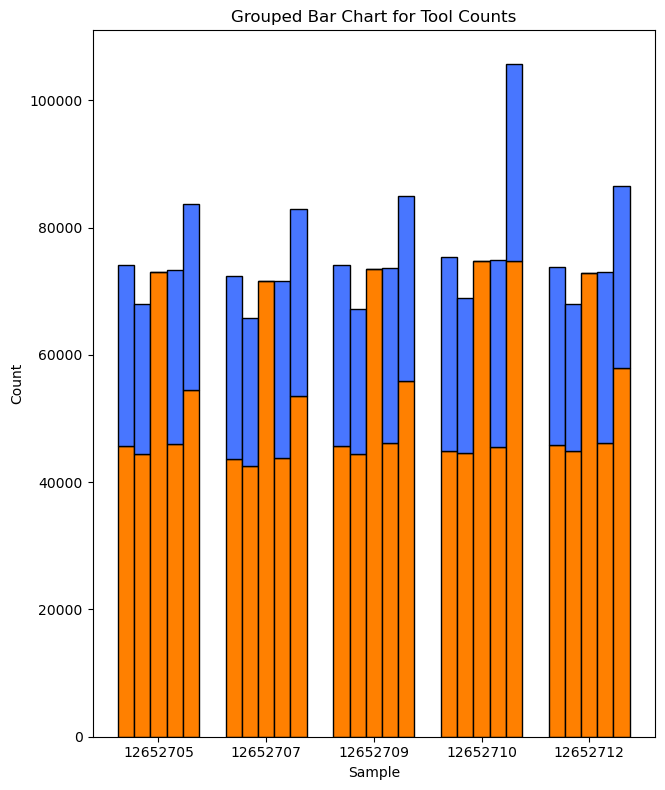

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Your data
data = {
    "Sample": [12652705, 12652705, 12652705, 12652705, 12652705,
               12652707, 12652707, 12652707, 12652707, 12652707,
               12652709, 12652709, 12652709, 12652709, 12652709,
               12652710, 12652710, 12652710, 12652710, 12652710,
               12652712, 12652712, 12652712, 12652712, 12652712],
    "Tool": ["BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT",
             "BCFTOOLS", "VARSCAN2", "MUTECT2", "HAPLOTYPECALLER", "DEEPVARIANT"],
    "HET_count": [45612, 44437, 73089, 45939, 54559,
                  43594, 42539, 71549, 43821, 53536,
                  45702, 44351, 73480, 46137, 55884,
                  44941, 44631, 74705, 45461, 74705,
                  45785, 44899, 72893, 46192, 57871],
    "HOM_count": [28467, 23559, 0, 27418, 29097,
                  28846, 23234, 0, 27825, 29417,
                  28462, 22844, 0, 27468, 29095,
                  30400, 24262, 0, 29405, 31016,
                  28006, 23161, 0, 26853, 28620]
}

df = pd.DataFrame(data)

# Create unique x-values for each sample
samples = df['Sample'].unique()
x = np.arange(len(samples))

# Width of each bar
bar_width = 0.15  # Adjust the bar width as needed

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Define custom colors for HET_count and HOM_count
het_color = '#FF8000'
hom_color = '#4876FF'

# Grouped bar chart for each tool (HET_count in blue and HOM_count in orange)
tools = df['Tool'].unique()
legend_labels = []  # To store legend labels in the correct order

for i, tool in enumerate(tools):
    het_counts = df[df['Tool'] == tool]['HET_count']
    hom_counts = df[df['Tool'] == tool]['HOM_count']

    # Comment out the line that creates labels for each bar
    # labels = [f'{sample}' for sample in samples]

    legend_labels.append(f'{tool} (HET_count)')
    legend_labels.append(f'{tool} (HOM_count')

    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, het_counts, bar_width, label=f'{tool} (HET_count)', color=het_color, edgecolor='black')
    ax.bar(x - bar_width * (len(tools) - 1) / 2 + i * bar_width, hom_counts, bar_width, label=f'{tool} (HOM_count)', bottom=het_counts, color=hom_color, edgecolor='black')

    # Comment out the lines that add labels for the overall counts on the bars (rotated)
    # for xi, overall_count in zip(x, het_counts + hom_counts):
    #     ax.text(xi - bar_width * (len(tools) - 1) / 2 + i * bar_width, overall_count, f'{overall_count}', ha='center', va='bottom', fontsize=10, rotation=90)

# Customize the plot
ax.set_xlabel('Sample')
ax.set_ylabel('Count')
ax.set_title('Grouped Bar Chart for Tool Counts')
ax.set_xticks(x)
ax.set_xticklabels(samples)

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=0)

# Place both legends outside the plot to the right
ax.legend(title='Tool', labels=legend_labels, bbox_to_anchor=(1.15, 1), loc='upper left')
custom_legend_labels = ["1. BCFTOOLS", "2. VARSCAN2", "3. MUTECT2", "4. HAPLOTYPECALLER", "5. DEEPVARIANT"]
custom_legend = plt.legend(custom_legend_labels, title='Tools', bbox_to_anchor=(1.15, 0.5), loc='center left')

# Show the plot
plt.tight_layout()

# Combine both legends
ax.add_artist(custom_legend)
plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Result/ALL_samples_bargraph.svg', dpi=450, bbox_inches='tight')
plt.show()

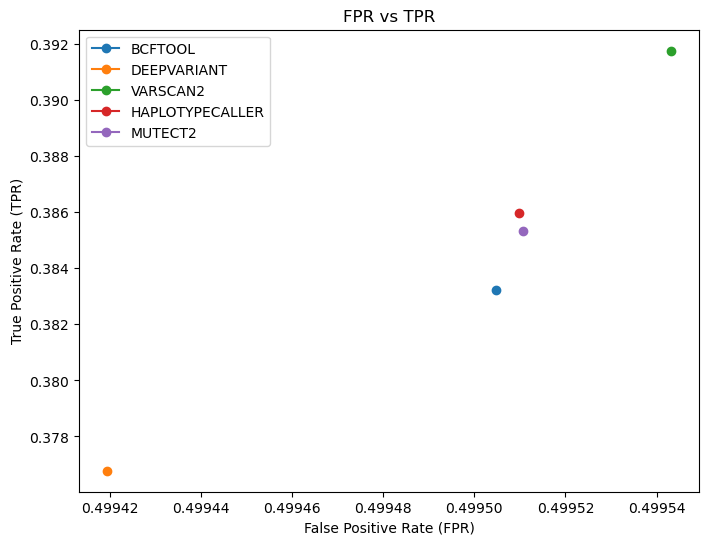

In [10]:
import matplotlib.pyplot as plt

# Data
tools = ["BCFTOOL", "DEEPVARIANT", "VARSCAN2", "HAPLOTYPECALLER", "MUTECT2"]
TP = [28278, 32588, 26663, 28192, 28089]
TN = [37281968, 37290358, 37277852, 37281308, 37281259]
FP = [37208177, 37203867, 37209792, 37208263, 37208366]
FN = [45513, 53903, 41397, 44853, 44804]

# Initialize a figure for ROC curves
plt.figure(figsize=(8, 6))

# Iterate over tools
for i in range(len(tools)):
    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    tpr = TP[i] / (TP[i] + FN[i])
    fpr = FP[i] / (TN[i] + FP[i])

    # Plot ROC curve
    plt.plot(fpr, tpr, marker='o', label=tools[i])

# Set axis labels and title
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('FPR vs TPR')

# Add legend
plt.legend()

plt.savefig(r'C:/Users/GenepoweRx_Madhu/Downloads/sen_spe_files_07_09_2023/VCC_input_files/Result/12652712_samples_FPR_TPR.svg', dpi=450, bbox_inches='tight')

# Show the ROC curves
plt.show()

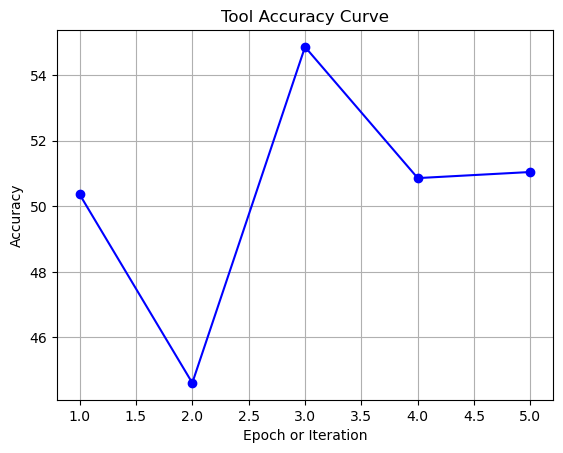

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual accuracy values
accuracy_values = [50.36587157, 44.61139787, 54.86271398, 50.86060226, 51.04672933]
epoch_numbers = np.arange(1, len(accuracy_values) + 1)

# Create the accuracy curve
plt.plot(epoch_numbers, accuracy_values, marker='o', linestyle='-', color='b')
plt.title('Tool Accuracy Curve')
plt.xlabel('Epoch or Iteration')
plt.ylabel('Accuracy')
plt.grid(True)

# Display the accuracy curve
plt.show()